<a href="https://www.kaggle.com/code/m101yosef/heart-failure-healthcare-ai-ep-1?scriptVersionId=252334554" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Can we predict heart failure from basic features?**

In this episode, we will try together to find out how much we can go with this simple data and simple features that we have. What is the accuracy level that we can get? How many models should we build? 

<br>

**About the Healthcare AI Series**

This will be a new series where I will choose a healthcare problem or topic and analyse it. This is not just another machine learning experiment. This is about people. It’s about using numbers to understand risk, reveal patterns, and hopefully, make a difference.

**Why?** I want to specialise in healthcare AI, and I believe the best way to learn is to work on real problems, not just tutorials. I also want to build a public body of work that reflects both skill and purpose — something that helps others while helping me grow.

# 0. Setup

In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# libraries for modelling 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'DejaVu Sans'

# load the data
URL = '/kaggle/input/heart-failure-prediction/heart.csv'
data = pd.read_csv(URL)

In [2]:
# Classify columns based on dataset documentation
cat_cols = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 
            'RestingECG', 'ST_Slope']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target_col = 'HeartDisease'

In [3]:
# Resuable function to plot features against the target variable
def plot_features(features, kind, 
                    data=data,
                    title='Features vs Target', 
                    target=target_col):
    """
    Plots multiple features against the target variable using different plot types.

    Parameters
    ----------
    features : list of str
        List of feature column names to plot.
    kind : str
        Type of plot to use. Options: 'count' (categorical countplot), 
        'box' (boxplot for numerical features), 'violin' (violin plot for numerical features), 
        'kde' (kernel density estimate for numerical features).
    data : pandas.DataFrame, optional
        DataFrame containing the data. Defaults to the global 'data'.
    title : str, optional
        Title for the entire figure. Defaults to 'Features vs Target'.
    target : str, optional
        Name of the target column. Defaults to the global 'target_col'.

    Returns
    -------
    None
        Displays the plots.
    """
    n_features = len(features)
    n_cols = 3
    n_rows = int(np.ceil(n_features / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        if kind == 'count':
            sns.countplot(data=data, x=feature, hue=target, palette=['teal', 'crimson'], ax=axes[i])
        elif kind == 'box':
            sns.boxplot(data=data, hue=target, y=feature, palette=['teal', 'crimson'], ax=axes[i])
        elif kind == 'violin':
            sns.violinplot(data=data, x=feature, hue=target, split=True, palette=['teal', 'crimson'], ax=axes[i])
        elif kind == 'kde':
            for label, color in zip([0, 1], ['teal', 'crimson']):
                subset = data[data[target] == label]
                sns.kdeplot(subset[feature], ax=axes[i], label=f'{target}={label}', color=color)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].set_title(feature, fontsize=16)
        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    fig.suptitle(f"{title}\n", fontsize=22, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 1. Data Understanding

Our dataset has 918 patient records with 12 features. The target variable, `HeartDisease`, indicates the presence (1) or absence (0) of heart disease. For the initial analysis, I will start with the dataset's size, structure, and key attributes, then I'll look at whether 'HeartDisease' cases are balanced or not. After that, I will explore how features related to 'HeartDisease' and&mdash;how they correlate with each other.

In [4]:
# missing values in the data
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Target Class Balance
The dataset is nearly balanced, with 44.7% of patients not having heart disease and 55.3% having heart disease. There are no missing values, which simplifies the data preparation process. 

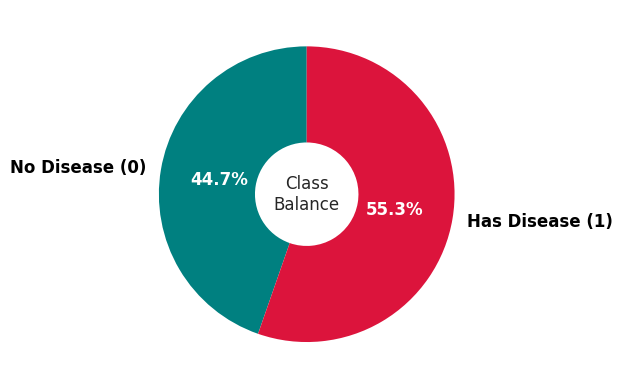

In [5]:
# Visualising class balance
class_balance = data['HeartDisease'].value_counts().sort_index(ascending=True)
wedges, texts, autotexts = plt.pie(
    class_balance,
    labels=['No Disease (0)', 'Has Disease (1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['teal', 'crimson'],
    wedgeprops={'width': 0.65}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.setp(texts, size=12, weight='bold', color='black')
plt.text(0, 0, 'Class\nBalance', ha='center', va='center', fontsize=12)
plt.gca().set_aspect('equal')
plt.show()

## Categorical features vs. target

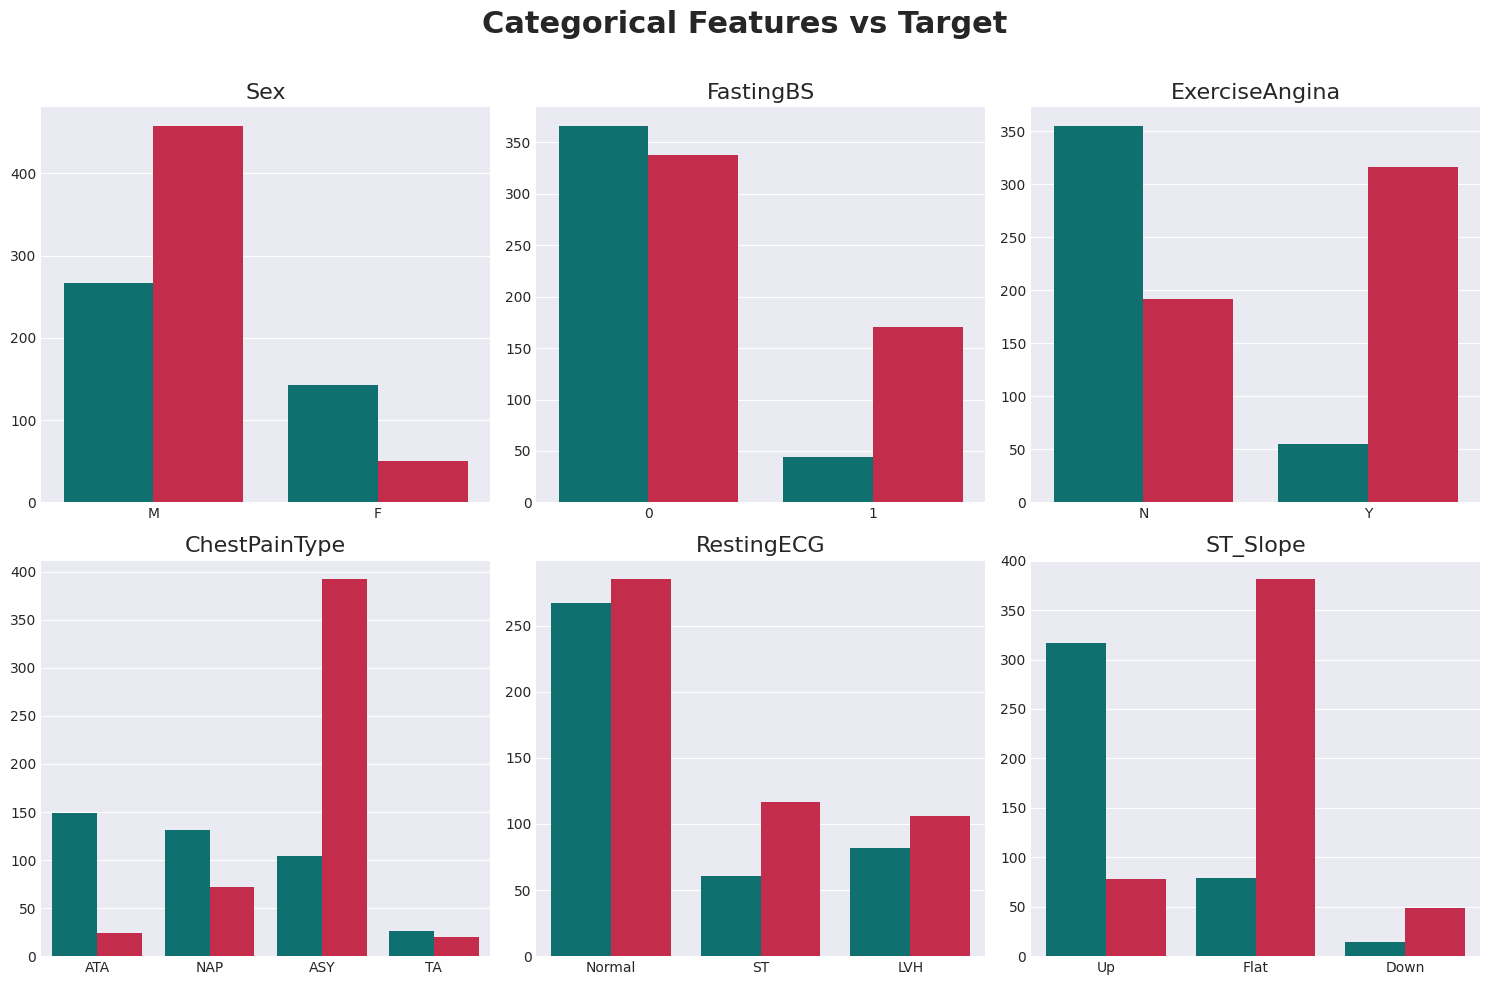

In [6]:
plot_features(features=cat_cols, title='Categorical Features vs Target', kind='count')

## Numerical features vs. target

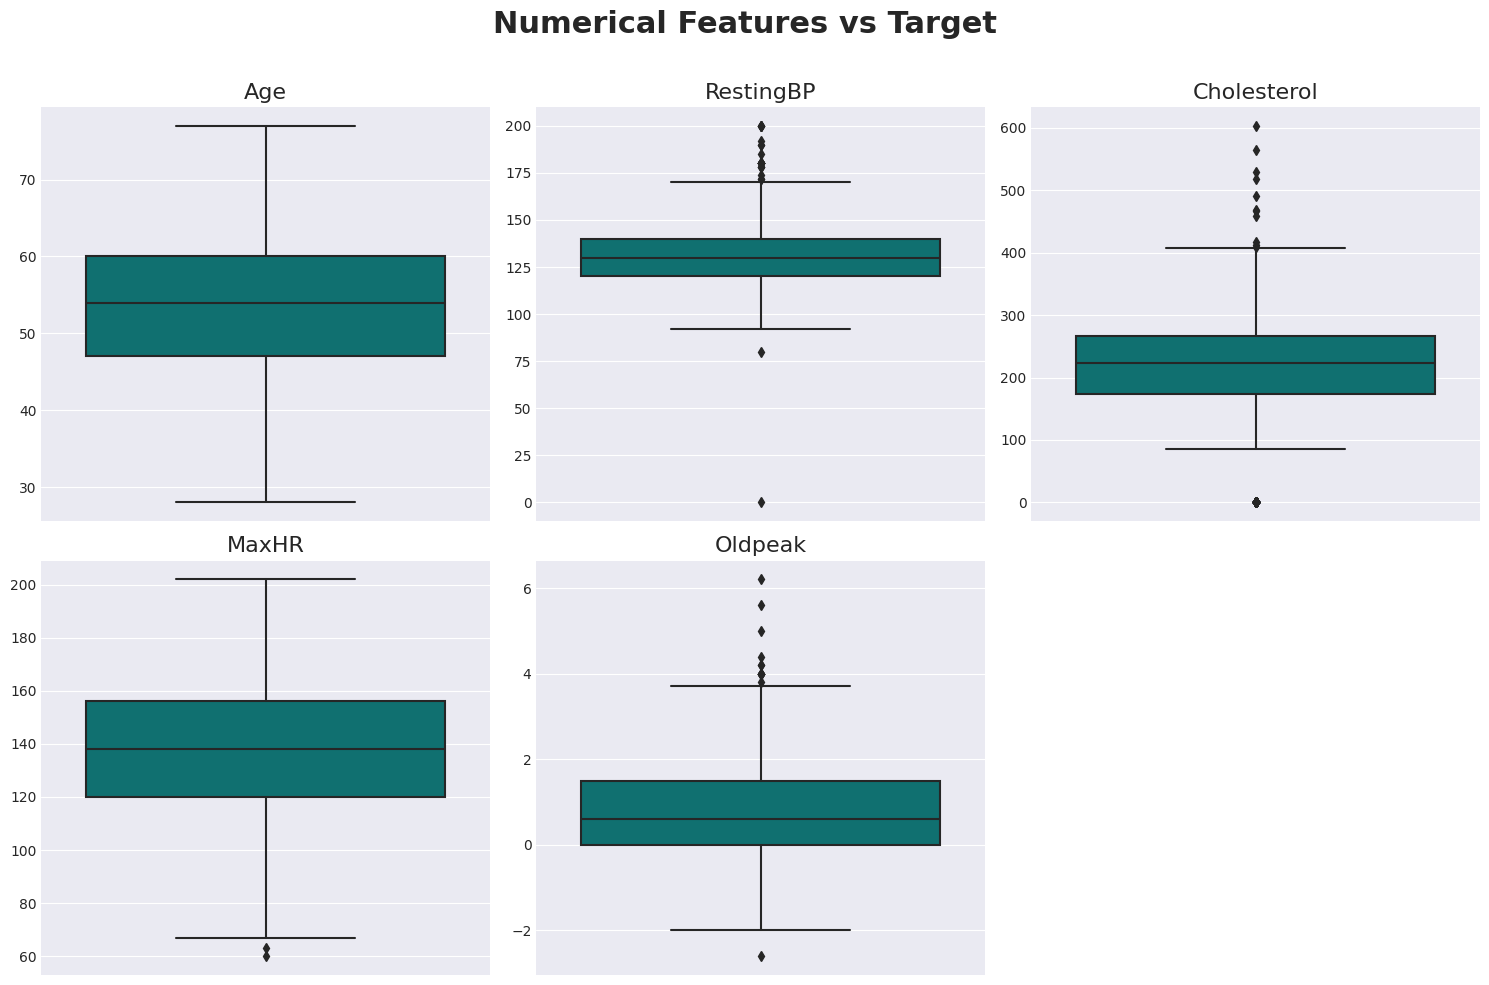

In [7]:
plot_features(features=num_cols, title='Numerical Features vs Target', kind='box')

There is something worng with Kaggle and the hue here is not working but below is the plot I want.

<br>

![num-vs-target](https://github.com/m101yosef/healthcare-ai/raw/main/1-heart-failure/image/num-vs-target.png)

## Features vs. target summary


<div style="margin-top: 1em; border-radius: 8px; overflow: hidden; box-shadow: 0 4px 12px rgba(0,0,0,0.08);">
<table style="border-collapse: collapse; width: 100%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 15px; background: white;">
    <thead>
    <tr style="background: linear-gradient(135deg, crimson, #2c3e50); color: white;">
        <th style="padding: 14px 16px; text-align: left; font-weight: 600;">Feature</th>
        <th style="padding: 14px 16px; text-align: left; font-weight: 600;">Risk Indicator</th>
        <th style="padding: 14px 16px; text-align: left; font-weight: 600;">Notes</th>
    </tr>
    </thead>
    <tbody>
    <tr><th>Categorical Features</th></tr>
    <tr style="transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">Sex = M</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; color: #e74c3c; font-weight: 500;">Higher risk</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Males are more prone to heart issues, especially at younger ages</td>
    </tr>
    <tr style="background-color: #f8f9fa; transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">FastingBS = 1</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; color: #e74c3c; font-weight: 500;">Higher risk</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">High fasting blood sugar (likely diabetic) increases heart risk</td>
    </tr>
    <tr style="transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">ExerciseAngina = Y</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; color: #e74c3c; font-weight: 500;">Higher risk</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Indicates chest pain during exertion — often a sign of blocked arteries</td>
    </tr>
    <tr style="background-color: #f8f9fa; transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">ChestPainType = ASY</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; color: #e74c3c; font-weight: 500;">Higher risk</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Asymptomatic patients can still have serious heart conditions</td>
    </tr>
    <tr style="transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">ST_Slope = Flat</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; color: #e74c3c; font-weight: 500;">Higher risk</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Associated with ST depression and reduced blood flow during exercise</td>
    </tr>
    <tr style="background-color: #f8f9fa; transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">RestingECG = LVH</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; color: #f39c12; font-weight: 500;">Moderate risk</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Suggests left ventricular hypertrophy — a possible indicator of strain</td>
    </tr>
    <tr><th>Numerical Features</th></tr>
    <tr style="transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">Age</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 500; color: #e74c3c;">↑ Higher age → ↑ risk</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Cardiovascular vulnerability increases with age</td>
    </tr>
    <tr style="background-color: #f8f9fa; transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">RestingBP</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 500;">Slightly elevated in heart disease</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Limited standalone predictive value due to significant group overlap</td>
    </tr>
    <tr style="transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">Cholesterol</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 500; color: #7f8c8d;">No clear pattern (inconclusive)</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Impact may be better assessed through feature combinations</td>
    </tr>
    <tr style="background-color: #f8f9fa; transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">MaxHR</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 500; color: #e74c3c;">↓ Lower in heart disease</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Reduced peak heart rate indicates impaired cardiac response to stress</td>
    </tr>
    <tr style="transition: background-color 0.2s;">
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 600;">Oldpeak</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1; font-weight: 500; color: #e74c3c;">↑ Higher in heart disease</td>
        <td style="padding: 12px 16px; border-bottom: 1px solid #ecf0f1;">Indicates ST depression, suggesting myocardial ischemia during exercise</td>
    </tr>
    </tbody>
</table>
</div>


## Numerical features distribution

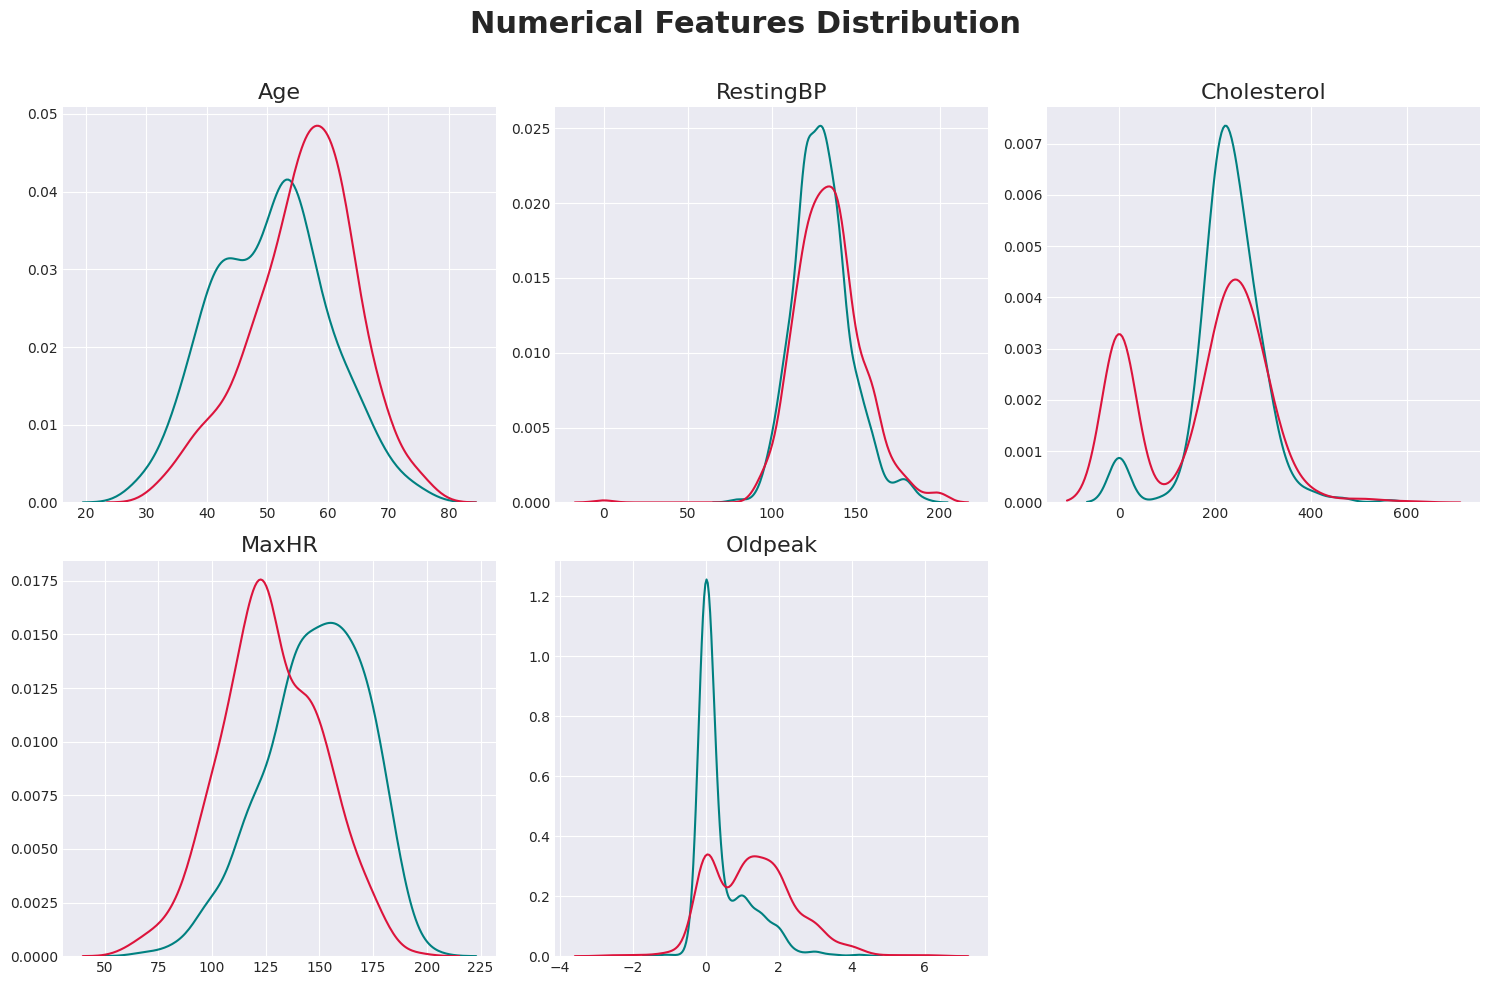

In [8]:
plot_features(features=num_cols, title='Numerical Features Distribution', kind='kde')

For Cholesterol and Oldpeak, there is a different distribution of values, indicating potential differences in heart stress responses and maybe I need to split these two features into more than one group of values (I will test this assumption later)

## Features correlation

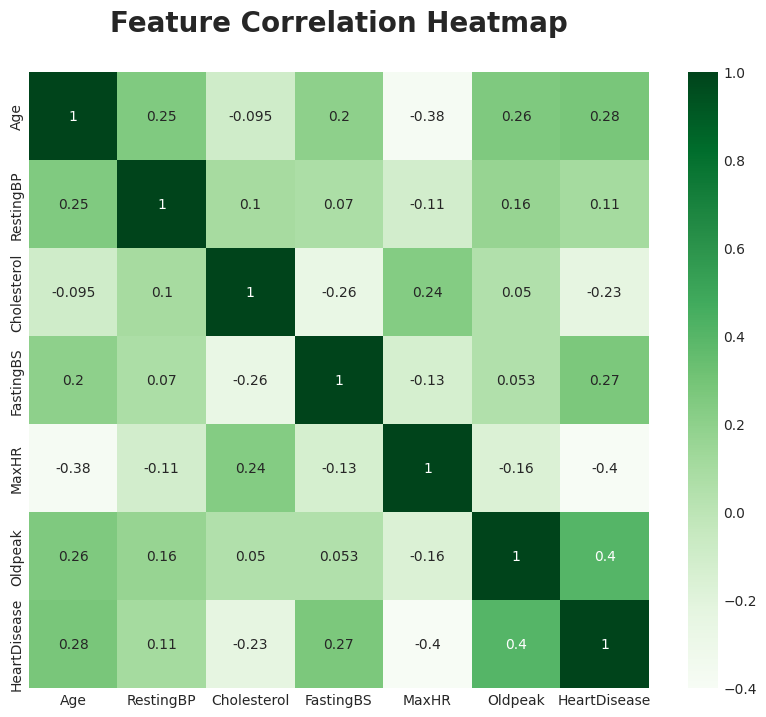

In [9]:
plt.figure(figsize=(10, 8))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='Greens')
plt.title('Feature Correlation Heatmap\n', fontsize=20, fontweight='bold')
plt.show()

MaxHR and Oldpeak show moderate negative and positive correlations with heart disease, respectively, suggesting these features are important predictors. However, the wide spread in cholesterol levels and the slight increase in resting blood pressure in the disease group indicate that these features may have a less direct impact on heart disease risk.

# 2. Add Features

Based on the results from exploring the numerical features distribution, we can create two features: 
- **Cholesterol groups** (levels: >80 ?)
- **Oldpeak groups** (levels: >0.7 ?)

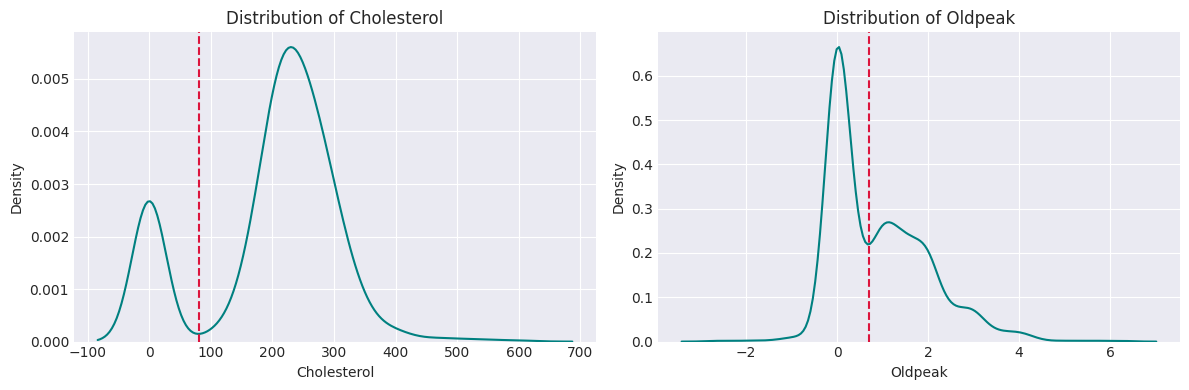

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Cholesterol distribution
sns.kdeplot(data=data, x='Cholesterol', ax=ax1, color='teal')
ax1.axvline(x=80, color='crimson', linestyle='--')
ax1.set_title('Distribution of Cholesterol')
ax1.set_xlabel('Cholesterol')

# Plot Oldpeak distribution
sns.kdeplot(data=data, x='Oldpeak', ax=ax2, color='teal')
ax2.axvline(x=0.7, color='crimson', linestyle='--')
ax2.set_title('Distribution of Oldpeak')
ax2.set_xlabel('Oldpeak')

plt.tight_layout()
plt.show()

In [11]:
# Binary classification of Cholesterol levels
data['LawChol'] = data['Cholesterol'] > 100
data['LawChol'] = data['LawChol'].astype(int)
data.groupby('HeartDisease')['LawChol'].value_counts()

HeartDisease  LawChol
0             1          388
              0           22
1             1          355
              0          153
Name: count, dtype: int64

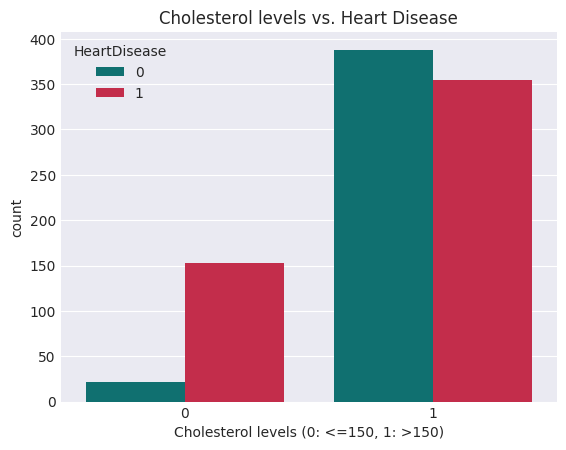

In [12]:
sns.countplot(x='LawChol', data=data, hue='HeartDisease', palette=['teal', 'crimson'])
plt.title('Cholesterol levels vs. Heart Disease')
plt.xlabel('Cholesterol levels (0: <=150, 1: >150)')
plt.show()

In [13]:
# Binary classification of Oldpeak levels
data['LawOldpeak'] = data['Oldpeak'] < 0.7
data['LawOldpeak'] = data['LawOldpeak'].astype(int)
data['LawOldpeak'].value_counts()

LawOldpeak
1    472
0    446
Name: count, dtype: int64

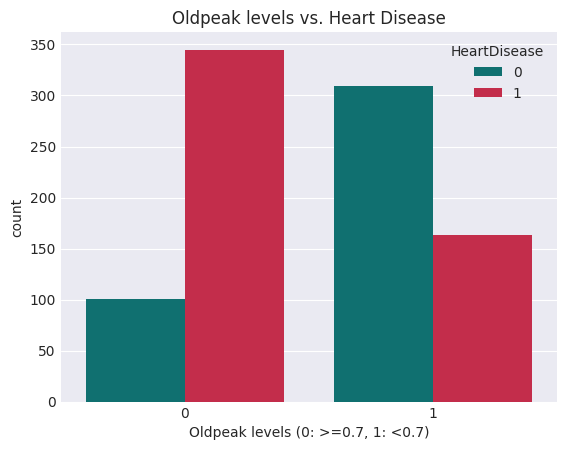

In [14]:
# Plotting Oldpeak levels against Heart Disease
sns.countplot(x='LawOldpeak', data=data, hue='HeartDisease', palette=['teal', 'crimson'])
plt.title('Oldpeak levels vs. Heart Disease')
plt.xlabel('Oldpeak levels (0: >=0.7, 1: <0.7)')
plt.show()

In [15]:
# update columns classification
cat_cols = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 
            'RestingECG', 'ST_Slope', 'LawChol', 'LawOldpeak']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target_col = 'HeartDisease'
data.shape

(918, 14)

# 3. Baseline Model - Random Forest

For a baseline model, I would start with a Random Forest classifier. It is generally robust, performs well across a variety of datasets, and is less prone to overfitting compared to single decision trees. It also provides a good balance between performance and complexity.

Splitted 
Train shape: (642, 13), Val shape: (138, 13), Test shape: (138, 13)


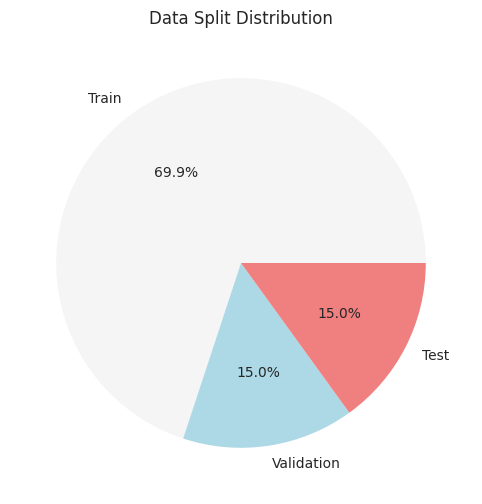

In [16]:
# Prepare features and target
y = data[target_col]
X = data.drop(columns=[target_col])

# Split data: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Splitted \nTrain shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# Calculate percentages
total_samples = len(X_train) + len(X_val) + len(X_test)
train_pct = len(X_train) / total_samples * 100
val_pct = len(X_val) / total_samples * 100
test_pct = len(X_test) / total_samples * 100

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie([train_pct, val_pct, test_pct], 
    labels=['Train', 'Validation', 'Test'],
    autopct='%1.1f%%',
    colors=['whitesmoke', 'lightblue', 'lightcoral'])
plt.title('Data Split Distribution')
plt.show()

In [17]:
# Encode categorical features for Random Forest
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[cat_cols])

def encode_and_concat(X):
    cat_encoded = encoder.transform(X[cat_cols])
    cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols), index=X.index)
    return pd.concat([X[num_cols].reset_index(drop=True), cat_encoded_df.reset_index(drop=True)], axis=1)

X_train_rf = encode_and_concat(X_train)
X_val_rf = encode_and_concat(X_val)
X_test_rf = encode_and_concat(X_test)

X_train_rf.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_N,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,LawChol_0,LawChol_1,LawOldpeak_0,LawOldpeak_1
0,52,140,259,170,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,53,123,282,95,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,53,120,274,130,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,51,150,200,120,0.5,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,59,130,318,120,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 0.8676
Validation Accuracy: 0.8260869565217391
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80        62
           1       0.82      0.88      0.85        76

    accuracy                           0.83       138
   macro avg       0.83      0.82      0.82       138
weighted avg       0.83      0.83      0.82       138

Confusion Matrix:
 [[47 15]
 [ 9 67]]


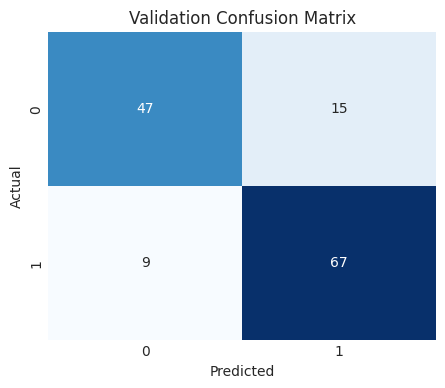

In [18]:
# Random Forest with Grid Search and Stratified K-Fold CV (using encoded data)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(rf, param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_train_rf, y_train)

print(f"Best parameters: {gs.best_params_}")
print(f"Best CV accuracy: {gs.best_score_:.4f}")

val_preds = gs.predict(X_val_rf)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

Test Accuracy: 0.8913043478260869
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88        62
           1       0.89      0.92      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138

Confusion Matrix:
 [[53  9]
 [ 6 70]]


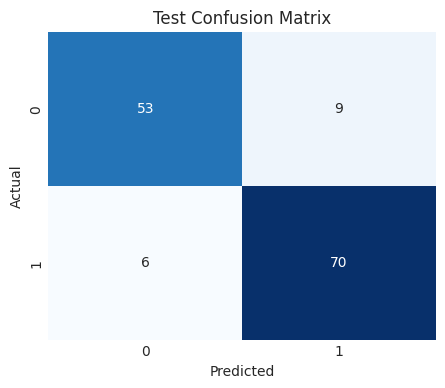

In [19]:
# Evaluate the best model on the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_preds = gs.predict(X_test_rf)
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Classification Report:\n", classification_report(y_test, test_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

**Interpretation**
- The model achieves a high test accuracy (~89%), indicating strong generalization to unseen data.
- Both classes are predicted with high precision and recall, with slightly better recall for the positive class (1).
- The confusion matrix shows a low number of false positives and false negatives.
- The model's performance on the test set is even better than on the validation set, suggesting robust training and no overfitting.

**Final Suggestions**
- Consider analysing feature importances to gain insights into which variables are most influential.
- If even higher performance is needed, try more advanced models or ensemble techniques.
- Continue monitoring for data drift or changes if deploying in a real-world setting.
- Document and communicate these results to stakeholders for further decision-making.

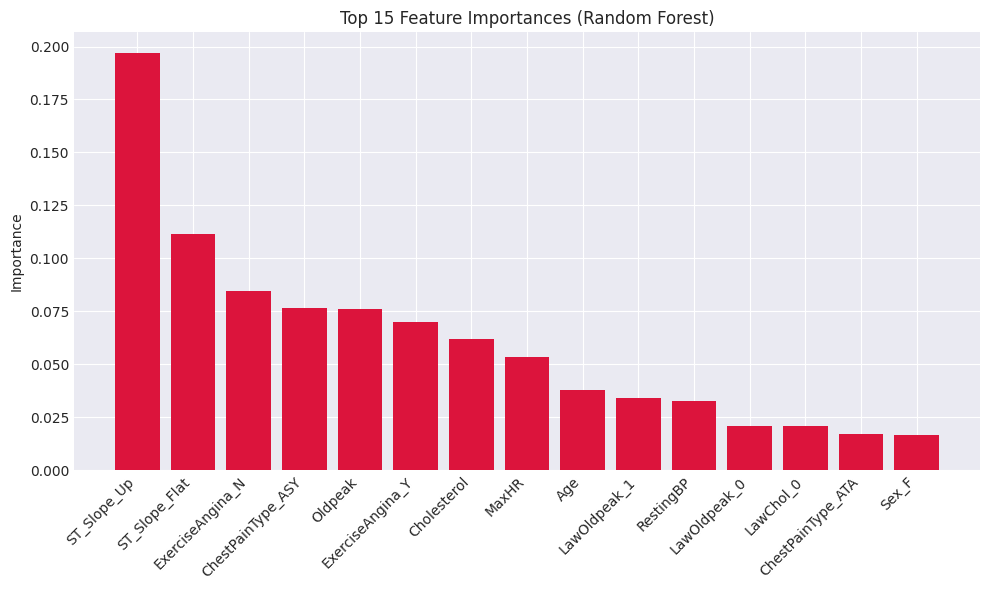

1. ST_Slope_Up: 0.1969
2. ST_Slope_Flat: 0.1117
3. ExerciseAngina_N: 0.0846
4. ChestPainType_ASY: 0.0766
5. Oldpeak: 0.0759
6. ExerciseAngina_Y: 0.0701
7. Cholesterol: 0.0617
8. MaxHR: 0.0535
9. Age: 0.0379
10. LawOldpeak_1: 0.0339
11. RestingBP: 0.0326
12. LawOldpeak_0: 0.0210
13. LawChol_0: 0.0207
14. ChestPainType_ATA: 0.0169
15. Sex_F: 0.0166
16. LawChol_1: 0.0155
17. ChestPainType_NAP: 0.0154
18. Sex_M: 0.0152
19. FastingBS_1: 0.0107
20. FastingBS_0: 0.0099
21. RestingECG_Normal: 0.0066
22. RestingECG_LVH: 0.0063
23. ST_Slope_Down: 0.0046
24. RestingECG_ST: 0.0028
25. ChestPainType_TA: 0.0025


In [20]:
# Analyze and plot feature importances
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best estimator
top_rf = gs.best_estimator_
importances = top_rf.feature_importances_
feature_names = list(X_train_rf.columns)

# Sort features by importance
dx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.bar(range(15), importances[dx][:15], align='center', color='crimson')
plt.xticks(range(15), [feature_names[i] for i in dx[:15]], rotation=45, ha='right')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Print all features
for i in range(25):
    print(f"{i+1}. {feature_names[dx[i]]}: {importances[dx[i]]:.4f}")

- **Most influential features:**  
  - `ST_Slope_Up` (0.1969) and `ST_Slope_Flat` (0.1117) are by far the most important, highlighting the predictive power of ST segment slope during exercise.
  - `ExerciseAngina_N` (0.0846) and `ExerciseAngina_Y` (0.0701) together indicate that the presence or absence of exercise-induced angina is a strong predictor.
  - `ChestPainType_ASY` (0.0766) and `Oldpeak` (0.0759) are also highly influential, aligning with clinical expectations.

- **Moderately important features:**  
  - `Cholesterol` (0.0617), `MaxHR` (0.0535), and `Age` (0.0379) contribute meaningfully, reflecting known cardiovascular risk factors.
  - Engineered features like `LawOldpeak_1` (0.0339), `RestingBP` (0.0326), `LawOldpeak_0` (0.0210), and `LawChol_0` (0.0207) also show moderate importance.
  - `ChestPainType_ATA` (0.0169), `Sex_F` (0.0166), `LawChol_1` (0.0155), `ChestPainType_NAP` (0.0154), and `Sex_M` (0.0152) have smaller but non-negligible contributions.

- **Least important features:**  
  - Features such as `FastingBS_1` (0.0107), `FastingBS_0` (0.0099), `RestingECG_Normal` (0.0066), `RestingECG_LVH` (0.0063), `ST_Slope_Down` (0.0046), `RestingECG_ST` (0.0028), and `ChestPainType_TA` (0.0025) have relatively low importance (<0.012).
  - These features contribute less to the model’s predictions, but their removal should only be considered if it does not reduce model performance.

**Summary & Suggestions**

- The model relies most on exercise-related ECG features and symptoms, which is consistent with medical knowledge.
- Demographic features (like sex) and fasting blood sugar have low importance in this dataset/model.
- Consider focusing on the most influential features for further analysis or model simplification.

In [21]:
# Save Random Forest model performance and feature importances to CSV
perf_rows = []
for split, X_, y_, preds in [
    ('validation', X_val_rf, y_val, val_preds),
    ('test', X_test_rf, y_test, test_preds),
    ]:
    perf_rows.append({
        'model': 'RandomForest',
        'split': split,
        'accuracy': accuracy_score(y_, preds),
        'precision': precision_score(y_, preds),
        'recall': recall_score(y_, preds),
        'f1': f1_score(y_, preds)
    })

# Save feature importances
fi_df = pd.DataFrame({
    'model': 'RandomForest',
    'feature': [feature_names[i] for i in dx[:25]],
    'importance': importances[dx[:25]]
})

# 4. Models Evaluation

I've repeated step 3 and built three other models: 
- XGBoost
- Logistic Regression 
- Multi-layer Perceptron (MLP)

I used grid search and cross-validation to find the best settings for each model. After that, I checked how well each model did on the validation and test sets, using accuracy, precision, recall, and F1-score.

<br>

If you want to see the code, visit [this repo](https://github.com/m101yosef/healthcare-ai/tree/main/1-heart-failure)

![Models Performance](https://github.com/m101yosef/healthcare-ai/raw/main/1-heart-failure/image/models-performance.png)

**Key Observations**
- All models performed similarly, with high accuracy (around 89%). 
- The most important features were things like ST segment slope, exercise-induced angina, chest pain type, and oldpeak.
- The models agree on what’s important, which matches what doctors expect.
- No single model was a clear winner, but all gave useful insights.

![Features importance](https://github.com/m101yosef/healthcare-ai/raw/main/1-heart-failure/image/features-importance.png)

Differences in feature importance rankings highlight how each model leverages different aspects of the data.

# Reflection
**What I Did Right**
- I used a fair data split and cross-validation to avoid overfitting.
- I tried several types of models, from simple to more complex.
- I checked feature importance to understand what drives predictions.
- I kept the process transparent and reproducible.

<br>

**What I Did Wrong / Could Improve**

- I could have tried more advanced models or combined models (ensembles) for even better results.
- I didn’t do much feature engineering—creating new features or combining existing ones might help.
- I could have looked for more data or tried to balance the classes if they were uneven.
- I didn’t use external validation (like data from another hospital) to check if the models generalize.
- I could have spent more time on data cleaning and outlier detection.

<br>

**Next Steps**

- Try ensemble methods: Combine several models for better accuracy.
- Add more data: More data usually means better models.
- Read research papers: See what the latest science says about heart disease prediction.
- Work with doctors: Get expert feedback to make the models more useful in real life.
- Deploy the model: Build a simple app or dashboard for doctors or patients.

<br><br>

Thank you for reading! <br>
*See you in the next episode*